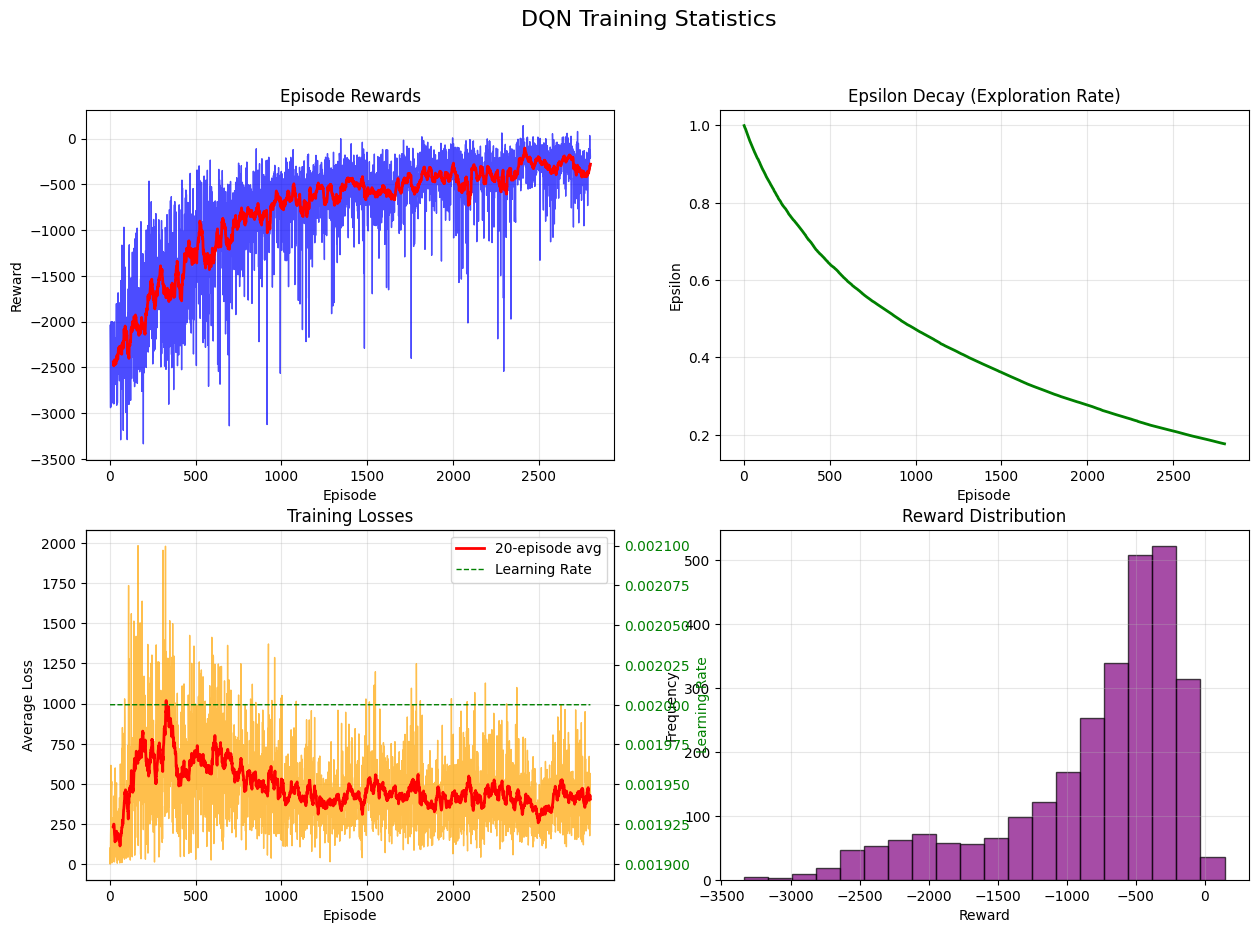

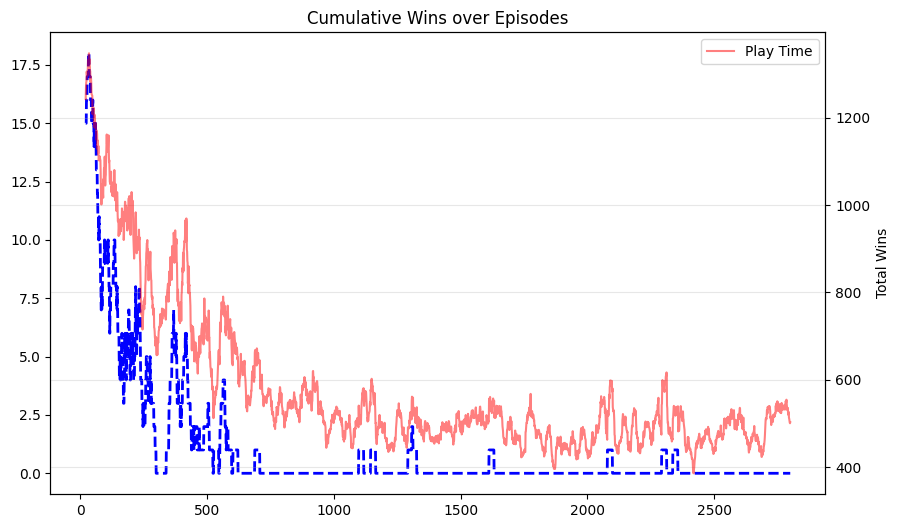

<Figure size 640x480 with 0 Axes>

Training Summary:
Total Episodes: 2800
Average Reward: -787.49 ± 656.24
Best Episode Reward: 143.00
Worst Episode Reward: -3336.00
Current Epsilon: 0.1768
Average Loss (last 50 episodes): 405.4286


In [52]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Read the training statistics file
with open('./agent/training_stats_pytorch.json', 'r') as f:
    stats = json.load(f)
# Create subplots for different metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('DQN Training Statistics', fontsize=16)

# Plot 1: Episode Rewards
axes[0, 0].plot(stats['episodes'], stats['rewards'], 'b-', alpha=0.7, linewidth=1, label='Reward')
axes[0, 0].set_title('Episode Rewards')
axes[0, 0].set_xlabel('Episode')
axes[0, 0].set_ylabel('Reward')
axes[0, 0].grid(True, alpha=0.3)

# Add rolling average for rewards
if len(stats['rewards']) > 10:
    window_size = min(20, len(stats['rewards']) // 5)
    rolling_avg = np.convolve(stats['rewards'], np.ones(window_size)/window_size, mode='valid')
    axes[0, 0].plot(stats['episodes'][window_size-1:], rolling_avg, 'r-', linewidth=2, label=f'{window_size}-episode avg')



# Plot 2: Epsilon Decay
axes[0, 1].plot(stats['episodes'], stats['epsilon'], 'g-', linewidth=2)
axes[0, 1].set_title('Epsilon Decay (Exploration Rate)')
axes[0, 1].set_xlabel('Episode')
axes[0, 1].set_ylabel('Epsilon')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Training Losses
if stats['losses']:
    axes[1, 0].plot(range(1, len(stats['losses']) + 1), stats['losses'], 'orange', alpha=0.7, linewidth=1)
    axes[1, 0].set_title('Training Losses')
    axes[1, 0].set_xlabel('Episode')
    axes[1, 0].set_ylabel('Average Loss')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Add rolling average for losses
    if len(stats['losses']) > 10:
        window_size = min(20, len(stats['losses']) // 5)
        loss_rolling_avg = np.convolve(stats['losses'], np.ones(window_size)/window_size, mode='valid')
        axes[1, 0].plot(range(window_size, len(stats['losses']) + 1), loss_rolling_avg, 'red', linewidth=2, label=f'{window_size}-episode avg')
        
        # Add learning rate line with secondary y-axis
        ax2 = axes[1, 0].twinx()
        ax2.set_ylabel('Learning Rate', color='g')
        ax2.plot(stats['episodes'], stats['learning_rate'], 'g--', linewidth=1, label='Learning Rate')
        ax2.tick_params(axis='y', labelcolor='g')
        
        # Combine legends from both axes
        lines1, labels1 = axes[1, 0].get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
else:
    axes[1, 0].text(0.5, 0.5, 'No loss data available', ha='center', va='center', transform=axes[1, 0].transAxes)
    axes[1, 0].set_title('Training Losses (No Data)')

# Plot 4: Reward Distribution
axes[1, 1].hist(stats['rewards'], bins=20, alpha=0.7, color='purple', edgecolor='black')
axes[1, 1].set_title('Reward Distribution')
axes[1, 1].set_xlabel('Reward')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(True, alpha=0.3)

# Plot wins
plt.figure(figsize=(10, 6))

# Add rolling average for deaths in last 100 episodes
if len(stats['deaths']) > 20:
    window_size = 20
    deaths_rolling = np.convolve(np.diff(stats['deaths']), np.ones(window_size)/1, mode='valid')
    plt.plot(stats['episodes'][window_size:], deaths_rolling, 'b--', linewidth=2, label=f'Deaths per {window_size} episodes')

    avg_play_time = np.convolve(stats['play_time'], np.ones(window_size+1)/(window_size+1), mode='valid')
    ax2 = plt.gca().twinx()  # Create second y-axis
    ax2.set_ylabel('Play Time')
    ax2.plot(stats['episodes'][window_size:], avg_play_time, 'r-', alpha=0.5, label=f'Play Time')
    # ax2.axhline(y=avg_play_time, color='r', linestyle='--', label=f'Avg Time: {avg_play_time:.1f}')
    ax2.legend(loc='upper right')

plt.title('Cumulative Wins over Episodes')
plt.xlabel('Episode')
plt.ylabel('Total Wins')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()
# Add statistics text

mean_reward = np.mean(stats['rewards'])
std_reward = np.std(stats['rewards'])
axes[1, 1].axvline(mean_reward, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_reward:.2f}')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Print summary statistics
print("Training Summary:")
print(f"Total Episodes: {len(stats['episodes'])}")
print(f"Average Reward: {mean_reward:.2f} ± {std_reward:.2f}")
print(f"Best Episode Reward: {max(stats['rewards']):.2f}")
print(f"Worst Episode Reward: {min(stats['rewards']):.2f}")
print(f"Current Epsilon: {stats['epsilon'][-1]:.4f}")
if stats['losses']:
    print(f"Average Loss (last 50 episodes): {np.mean(stats['losses'][-50:]):.4f}")


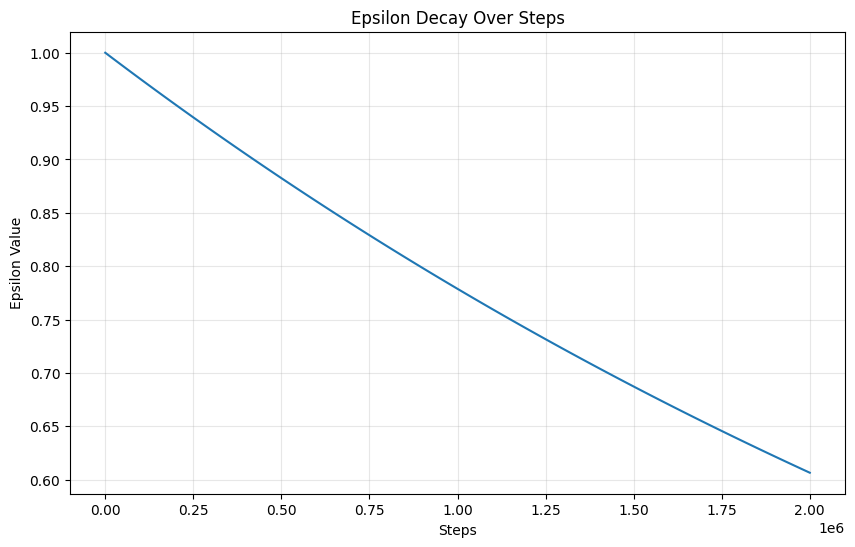

In [445]:
start = 1
series = []
for i in range(2000000):
    if i % 4 == 0:
        start *= 0.999999

    series.append(start)

# Plot epsilon decay series
plt.figure(figsize=(10,6))
plt.plot(series)
plt.title('Epsilon Decay Over Steps')
plt.xlabel('Steps') 
plt.ylabel('Epsilon Value')
plt.grid(True, alpha=0.3)
plt.show()


In [185]:
import asyncio
import websockets
import json

async def get_qvalues_from_agent(test_state):
    """Connect to the agent and get Q-values for a test state"""
    try:
        # Connect to the agent's WebSocket server
        uri = "ws://localhost:5000"
        async with websockets.connect(uri) as websocket:
            # Send test state with 'test' flag
            test_data = {
                'test': True,
                'x': test_state[0],
                'y': test_state[1], 
                'heading': test_state[2],
                'energy': test_state[3],
                'gunHeat': test_state[4],
                'velocity': test_state[5],
                'distanceRemaining': test_state[6],
                'enemyBearing': test_state[7],
                'enemyDistance': test_state[8] if len(test_state) > 8 else 100,
                'enemyHeading': test_state[9] if len(test_state) > 9 else 0,
                'reward': 0
            }
            
            await websocket.send(json.dumps(test_data))
            
            # Receive Q-values response
            response = await websocket.recv()
            q_values = json.loads(response)
            
            return q_values
            
    except Exception as e:
        print(f"Error connecting to agent: {e}")
        return None

# Test the connection and get Q-values for sample states
print("Testing Q-values from live agent...")
print("Make sure the agent is running on localhost:5000")

# Example test state: [x, y, heading, energy, gunHeat, velocity, distanceRemaining, enemyBearing, enemyDistance, enemyHeading]
sample_state = [400, 300, 0, 100, 0, 0, 0, 45, 150, 90]

try:
    # Run the async function
    q_values = get_qvalues_from_agent(sample_state)
    print(q_values)
    if q_values:
        print(f"\nQ-values for test state {sample_state}:")
        action_names = [
            "Move Forward", "Move Backward", "Turn Left", "Turn Right", 
            "Fire", "Move Forward + Fire", "Move Backward + Fire", "Turn + Fire"
        ]
        
        for i, (action, q_val) in enumerate(zip(action_names, q_values)):
            print(f"  {i}: {action:<20} Q-value: {q_val:.4f}")
        
        # Show best action
        best_action_idx = q_values.index(max(q_values))
        print(f"\nBest action: {action_names[best_action_idx]} (Q-value: {max(q_values):.4f})")
    else:
        print("Failed to get Q-values from agent")
        
except Exception as e:
    print(f"Error: {e}")
    print("Make sure the PyTorch agent is running and listening on localhost:5000")



ModuleNotFoundError: No module named 'websockets'

In [24]:

try:
    # Load the model state dict
    
    model_path = './dqn_model_pytorch.pth'
    model_state = torch.load(model_path, map_location='cpu', weights_only=False)
    print(f"Successfully loaded model from {model_path}")
    
    # Create a new model instance (assuming same architecture as training)
    from torch import nn
    
    class DQN(nn.Module):
        def __init__(self, input_size=10, hidden_size=128, output_size=8):
            super(DQN, self).__init__()
            self.network = nn.Sequential(
                nn.Linear(input_size, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, output_size)
            )
        
        def forward(self, x):
            return self.network(x)
    
    # Initialize model and load weights
    model = DQN()
    model.load_state_dict(model_state)
    model.eval()
    
    # Test states (example robot states)
    test_states = [
        [400, 300, 0, 0, 500, 400, 50, 100],      # Robot at center, enemy nearby
        [100, 100, 45, 0, 200, 200, 30, 100],     # Robot near corner, enemy diagonal
        [700, 500, 90, 0, 300, 100, 80, 100],     # Robot near edge, enemy far
        [350, 250, 180, 0, 360, 260, 10, 100],    # Robot close to enemy
        [50, 50, 270, 0, 750, 550, 100, 100],     # Robot in corner, enemy far
    ]
    
    action_names = [
        "Move Forward", "Move Backward", "Turn Left", "Turn Right",
        "Fire", "Move Forward + Fire", "Move Backward + Fire", 
        "Turn Left + Fire", "Turn Right + Fire"
    ]
    
    print("\nTesting trained model on sample states:")
    print("-" * 60)
    
    with torch.no_grad():
        for i, state in enumerate(test_states):
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            q_values = model(state_tensor)
            predicted_action = torch.argmax(q_values, dim=1).item()
            confidence = torch.softmax(q_values, dim=1)[0]
            
            print(f"\nTest State {i+1}:")
            print(f"  Robot Position: ({state[0]:.0f}, {state[1]:.0f})")
            print(f"  Robot Heading: {state[2]:.0f}°")
            print(f"  Enemy Position: ({state[4]:.0f}, {state[5]:.0f})")
            print(f"  Distance to Enemy: {state[6]:.0f}")
            print(f"  Energy: {state[7]:.0f}")
            print(f"  Predicted Action: {action_names[predicted_action]}")
            print(f"  Confidence: {confidence[predicted_action]:.3f}")
            print(f"  Q-values: {q_values[0].numpy()}")
    
    # Test model performance statistics
    print("\n" + "="*60)
    print("Model Performance Analysis:")
    print("="*60)
    
    # Generate more test cases for statistical analysis
    np.random.seed(42)
    num_test_cases = 100
    random_states = []
    
    for _ in range(num_test_cases):
        state = [
            np.random.uniform(50, 750),   # x position
            np.random.uniform(50, 550),   # y position  
            np.random.uniform(0, 360),    # heading
            np.random.uniform(-5, 5),     # velocity
            np.random.uniform(50, 750),   # enemy x
            np.random.uniform(50, 550),   # enemy y
            np.random.uniform(10, 200),   # distance to enemy
            np.random.uniform(20, 100)    # energy
        ]
        random_states.append(state)
    
    action_counts = {name: 0 for name in action_names}
    
    with torch.no_grad():
        for state in random_states:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            q_values = model(state_tensor)
            predicted_action = torch.argmax(q_values, dim=1).item()
            action_counts[action_names[predicted_action]] += 1
    
    print(f"\nAction Distribution (over {num_test_cases} random states):")
    for action, count in action_counts.items():
        percentage = (count / num_test_cases) * 100
        print(f"  {action}: {count} times ({percentage:.1f}%)")

except FileNotFoundError:
    print(f"Model file '{model_path}' not found. Please ensure the model has been trained and saved.")
except Exception as e:
    print(f"Error loading or testing model: {e}")


Successfully loaded model from ./dqn_model_pytorch.pth
Error loading or testing model: Error(s) in loading state_dict for DQN:
	Missing key(s) in state_dict: "network.0.weight", "network.0.bias", "network.2.weight", "network.2.bias", "network.4.weight", "network.4.bias". 
	Unexpected key(s) in state_dict: "q_network_state_dict", "target_network_state_dict", "optimizer_state_dict", "epsilon", "memory". 
